# <div align="center">Anomaly Detection on Credit Card Transactions</div>
### <div align="center">Author: <a href="https://www.linkedin.com/in/kaming-yip-22b03a1a0/">Kaming Yip</a>&emsp;&emsp;Date: Apr. 10, 2020</div>

### 1. Introduction

Anomaly detection is the process of identifying rare items, events, or observations which do not conform to expected behavior and raise suspicions by differing significantly from the majority of the data. The term anomaly is also referred to as outlier, so the technique is also called outlier detection. Applications of anomaly detection in the business world include intrusion detection (identifying strange patterns in the network traffic that could signal a hack), health monitoring system in the hospital, fraud detection in credit card transactions in banks, and industry damage detection.

In this project, we will take the credit card fraud detection as the case study for understanding this concept in detail. It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### 2. Data Description

The dataset we will use in this case is found on <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Kaggle</a>, contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in 2 days, where we have 492 frauds out of 284,807 transactions, highly imbalanced.

The first 5 rows of the dataset are displayed as follows:

In [1]:
import pandas as pd

In [2]:
creditcard = pd.read_csv("creditcard.csv", low_memory = False)
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset contains only numerical input variables which are the result of a <a href="https://en.wikipedia.org/wiki/Principal_component_analysis">Principal Component Analysis (PCA) transformation</a>. Unfortunately, due to confidentiality issues, the original features and more background information about the data are concealed. Features V1, V2, ..., V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependent cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### 3. Methodology

#### 3.1 Exploratory Data Analysis

##### 3.1.i. Distribution of Classes

The first question we might ask is how the target variable distributes. We have been notified that the label data is highly imbalanced, but it is still useful if we can actually visualize it.

In [3]:
import matplotlib.pyplot as plt

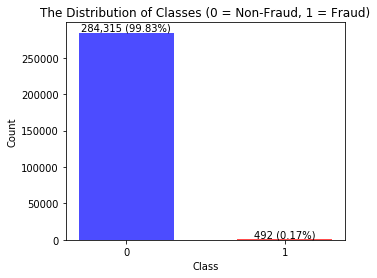

In [4]:
class_count = creditcard.groupby("Class")["Class"].size().to_frame(name = "Count")

plt.figure(figsize = (5, 4))
f_class = plt.bar(class_count.index, class_count["Count"], width = 0.6,
                  align = "center", alpha = 0.7, color = ["blue", "red"])
plt.title("The Distribution of Classes (0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.xticks(class_count.index)
plt.ylabel("Count")
for i in f_class:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.0, height,
             "{0} ({1:.2f}%)".format(format(int(height), ","), height/sum(class_count["Count"])*100),
             ha = "center", va = "bottom")
plt.show()

As shown in the bar plot, 99.83% of the data is identified as non-fraud and only 0.17% of the transactions are marked as fraud. In this project, we would like to explore how imbalanced data will perform in predicting the fraud transactions and how different sampling approaches can help in this circumstance.

##### 3.1.ii. Distribution of Amount and Time

Besides the target column, <i>Class</i>, we have another two columns that describe the transaction amount and occurred time. To explore in which way these two columns can influence the target variable, we can visualize their distribution in each class, respectively.

In [5]:
import numpy as np

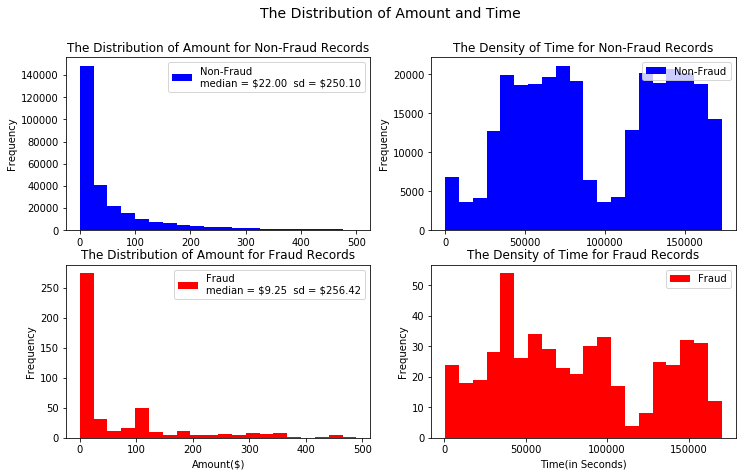

In [6]:
normal_records = creditcard.loc[creditcard["Class"] == 0, ["Time", "Amount", "Class"]].copy()
fraud_records = creditcard.loc[creditcard["Class"] == 1, ["Time", "Amount", "Class"]].copy()

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 7))
fig.suptitle("The Distribution of Amount and Time", fontsize = 14)

axes[0, 0].hist(normal_records.loc[normal_records["Amount"] < 500, "Amount"], bins = 20, color = "blue")
axes[0, 0].set_title("The Distribution of Amount for Non-Fraud Records")
axes[0, 0].legend(["Non-Fraud\n" + "median = \${0:.2f}  sd = \${1:.2f}".\
                  format(np.median(normal_records["Amount"]), np.std(normal_records["Amount"]))],
                  loc = "upper right")

axes[1, 0].hist(fraud_records.loc[fraud_records["Amount"] < 500, "Amount"], bins = 20, color = "red")
axes[1, 0].set_title("The Distribution of Amount for Fraud Records")
axes[1, 0].set_xlabel("Amount($)")
axes[1, 0].legend(["Fraud\n" + "median = \${0:.2f}  sd = \${1:.2f}".\
                  format(np.median(fraud_records["Amount"]), np.std(fraud_records["Amount"]))],
                  loc = "upper right")

axes[0, 1].hist(normal_records["Time"], bins = 20, color = "blue")
axes[0, 1].set_title("The Density of Time for Non-Fraud Records")
axes[0, 1].legend(["Non-Fraud"], loc = "upper right")

axes[1, 1].hist(fraud_records["Time"], bins = 20, color = "red")
axes[1, 1].set_title("The Density of Time for Fraud Records")
axes[1, 1].set_xlabel("Time(in Seconds)")
axes[1, 1].legend(["Fraud"], loc = "upper right")

plt.setp((axes[0, 0], axes[1, 0]), xticks = np.arange(0, 550, 100), ylabel = "Frequency")
plt.setp((axes[0, 1], axes[1, 1]), xticks = np.arange(0, 200000, 50000), ylabel = "Frequency")
plt.show()

By comparing the distribution of Amount and Time for Non-Fraud records and Fraud records, we can hardly find any clear patterns to distinguish the two classes. To be more specific, the transaction amount in either class shares a similar pattern that most of the transactions are purchases with small amount of money, especially less than $100. As for the transaction time, the fraud transactions also share similar fluctuations with the normal transactions.

##### 3.1.iii. Correlation Matrix between Features

Although the metadata for the Features V1-V28 is not able to access, we still can check the correlation among the features as well as with the target variable. Since all the variables are numerical, it is convenient for us to include all features into an integrated correlation matrix.

In [7]:
import seaborn as sns

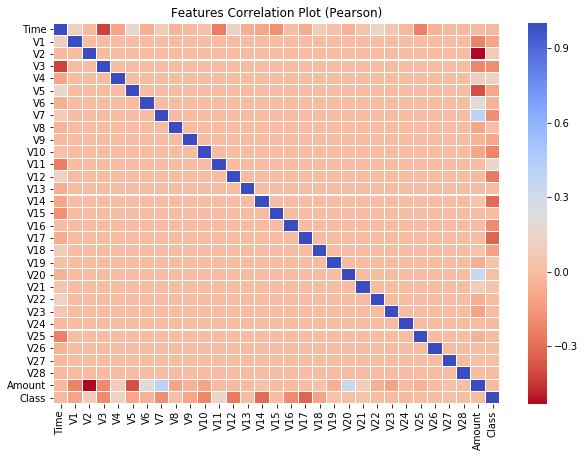

In [8]:
corr = creditcard.corr()

plt.figure(figsize = (10, 7))
plt.title("Features Correlation Plot (Pearson)")
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = 0.1, cmap = "coolwarm_r")
plt.show()

As shown in the correlation plot, none of the V1 to V28 PCA components have any strong correlation to each other. However, some of these features are either positively or negatively correlated to the output variable <i>Class</i>. Therefore, we do not need to worry about multicollinearity problem in this instance.

#### 3.2 Modeling

Taking the size of predictors and records into consideration, multilayer feedforward <b>Neural Networks</b>, which is one of the most common applications of neural networks in data mining, is applied in this project.

<img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="400" align="center" />

The graph shown above is a typical structure of the feedforward neural networks. In this structure, Input nodes take the values of the predictors as their input. Their output is the same as the input. The last layer is called the output layer, which produces the predicted output of the model, <i>SEVERITYCODE</i> in this case. The layers between the input and output layers are known as hidden layers. Those layers of nodes (sometimes called <i>neurons</i>) take the previous output values as their input. And the outputs of nodes in each layer are inputs to nodes in the next layer.

Neural Networks mimic the biological activity in the human brain, where neurons are interconnected and learn from experience. They can capture complex, or generally unknown, relationships between predictors and an outcome variable, which is often not possible with other predictive models.

We will first normalize all columns except target variable <i>Class</i>, then split the data into training set and testing set. Luckily, since neural network can only work with numerical data, we will build the models without further preprocessing.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
random_seed = 1

norm_columns = creditcard.columns.tolist()
norm_columns = [col for col in norm_columns if col not in ["Class"]]
creditcard_norm = creditcard.copy()
scaler = StandardScaler().fit(creditcard_norm[norm_columns].values)
creditcard_norm[norm_columns] = scaler.transform(creditcard_norm[norm_columns].values)
        
train_df, test_df = train_test_split(creditcard_norm, test_size = 0.4, random_state = random_seed)
X_train = train_df.drop("Class", axis = 1)
y_train = train_df["Class"]
X_test = test_df.drop("Class", axis = 1)
y_test = test_df["Class"]
train_test_sum = pd.DataFrame({"Dataset": ["Training", "Testing", "Total"],
                               "Records Num": ["{0:,}({1:.2f}%)".format(len(train_df), len(train_df)/len(creditcard_norm)*100),
                                               "{0:,}({1:.2f}%)".format(len(test_df), len(test_df)/len(creditcard_norm)*100),
                                               "{0:,}({1:.2f}%)".format(len(creditcard_norm), len(creditcard_norm)/len(creditcard_norm)*100)],
                               "Non-Fraud Num": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["Class"] == 0]), len(train_df[train_df["Class"] == 0])/len(train_df)*100),
                                                "{0:,}({1:.2f}%)".format(len(test_df[test_df["Class"] == 0]), len(test_df[test_df["Class"] == 0])/len(test_df)*100),
                                                "{0:,}({1:.2f}%)".format(len(creditcard_norm[creditcard_norm["Class"] == 0]),
                                                                         len(creditcard_norm[creditcard_norm["Class"] == 0])/len(creditcard_norm)*100)],
                               "Fraud Num": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["Class"] == 1]), len(train_df[train_df["Class"] == 1])/len(train_df)*100),
                                             "{0:,}({1:.2f}%)".format(len(test_df[test_df["Class"] == 1]), len(test_df[test_df["Class"] == 1])/len(test_df)*100),
                                             "{0:,}({1:.2f}%)".format(len(creditcard_norm[creditcard_norm["Class"] == 1]),
                                                                      len(creditcard_norm[creditcard_norm["Class"] == 1])/len(creditcard_norm)*100)]})

train_test_sum

,Dataset,Records Num,Non-Fraud Num,Fraud Num
0,Training,"170,884(60.00%)","170,578(99.82%)",306(0.18%)
1,Testing,"113,923(40.00%)","113,737(99.84%)",186(0.16%)
2,Total,"284,807(100.00%)","284,315(99.83%)",492(0.17%)


As mentioned before, since the raw data has highly imbalanced labels, two sampling approaches will be applied to handle this problem in order to compare the model performance against the model constructed by the original imbalanced dataset. Notice that we will only balance the training dataset and remain the testing set unchanged to reflect the original data imbalance.

In original approach, we simply separates the entire dataset into training data and testing data, keeping the training data imbalanced. Therefore, no more processes are needed in this approach.

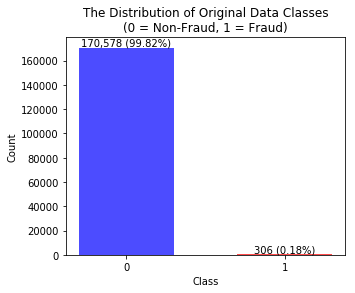

In [11]:
original_class_count = pd.DataFrame(y_train).groupby("Class")["Class"].size().to_frame(name = "Count")

plt.figure(figsize = (5, 4))
f_class = plt.bar(original_class_count.index, original_class_count["Count"], width = 0.6,
                  align = "center", alpha = 0.7, color = ["blue", "red"])
plt.title("The Distribution of Original Data Classes\n(0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.xticks(original_class_count.index)
plt.ylabel("Count")
for i in f_class:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.0, height,
             "{0} ({1:.2f}%)".format(format(int(height), ","), height/sum(original_class_count["Count"])*100),
             ha = "center", va = "bottom")
plt.show()

The first sampling method is called <b>undersampling approach</b>, which is to delete instances from the over-represented class, which is non-fraud (Class = 0), and keep an equal balance between the majority and minority class. Here we apply the simplest undersampling method which involves randomly deleting examples from the majority class, referred as <b>random undersampling</b>.

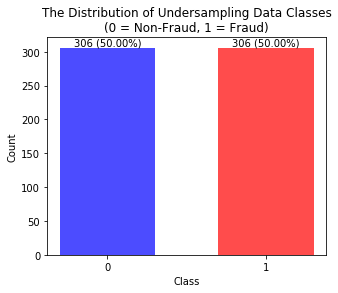

In [12]:
train_undersample = train_df.sample(frac = 1, random_state = random_seed)
fraud_df = train_undersample.loc[train_undersample["Class"] == 1]
no_fraud_df = train_undersample.loc[train_undersample["Class"] == 0][:len(train_undersample[train_undersample["Class"] == 1])]

undersample_df = pd.concat([fraud_df, no_fraud_df])
undersample_df = undersample_df.sample(frac = 1, random_state = random_seed)
undersample_class_count = undersample_df.groupby("Class")["Class"].size().to_frame(name = "Count")
        
plt.figure(figsize = (5, 4))
f_class = plt.bar(undersample_class_count.index, undersample_class_count["Count"], width = 0.6,
                  align = "center", alpha = 0.7, color = ["blue", "red"])
plt.title("The Distribution of Undersampling Data Classes\n(0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.xticks(undersample_class_count.index)
plt.ylabel("Count")
for i in f_class:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.0, height,
             "{0} ({1:.2f}%)".format(height.astype(int), height/sum(undersample_class_count["Count"])*100),
             ha = "center", va = "bottom")
plt.show()

The other sampling method is called the Synthetic Minority Oversampling Technique, or <b>SMOTE</b> for short. SMOTE is one of the most popular and perhaps most successful oversampling methods to synthesize new examples. It works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space, and drawing a new sample at a point along that line. The approach is effective because new synthetic examples from the minority class that are created are plausible, that is, are relatively close in the feature space to existing examples from the minority class.

By using this approach, we will create synthetic points from the minority class, which is <i>Fraud</i> (Class = 1), in order to reach an equal balance between the minority and majority class.

In [13]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


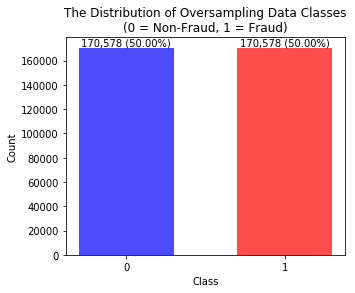

In [14]:
sm = SMOTE(random_state = random_seed)
oversampling_X_train, oversampling_y_train = sm.fit_sample(X_train, y_train)
oversampling_class_count = pd.DataFrame(oversampling_y_train).groupby("Class")["Class"].size().to_frame(name = "Count")
        
plt.figure(figsize = (5, 4))
f_class = plt.bar(oversampling_class_count.index, oversampling_class_count["Count"], width = 0.6,
                  align = "center", alpha = 0.7, color = ["blue", "red"])
plt.title("The Distribution of Oversampling Data Classes\n(0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.xticks(oversampling_class_count.index)
plt.ylabel("Count")
for i in f_class:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.0, height,
             "{0} ({1:.2f}%)".format(format(int(height), ","), height/sum(oversampling_class_count["Count"])*100),
             ha = "center", va = "bottom")
plt.show()

After the data sampling approaches, we now start to build the neural network models by using the resampling datasets, respectively. We will define our own confusion matrix function to better visualize the performance, including Accuracy, Recall, Precision, and F1 score, of each model.

In [15]:
from tabulate import tabulate
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam

tf.random.set_seed(random_seed)
np.random.seed(random_seed)

def get_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
            
def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def designed_confusion_matrix(train_actual, train_pred, train_title,
                              test_actual, test_pred, test_title, classes):
    fig = plt.figure(figsize = (8, 5))
            
    fig.add_subplot(221)
    train_cm = confusion_matrix(train_actual, train_pred)
    plt.imshow(train_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(train_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
        plt.text(j, i, format(train_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")      
    plt.xlabel("Predicted Class")
            
    fig.add_subplot(222)
    test_cm = confusion_matrix(test_actual, test_pred)
    plt.imshow(test_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(test_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
        plt.text(j, i, format(test_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    plt.show()
            
    stats_summary = pd.DataFrame(columns = ["Training Data", "Testing Data"],
                                 index = ["Accuracy", "Recall", "Precision", "F1 Score"])
    stats_set = [[train_actual, train_pred], [test_actual, test_pred]]
    for i, ele in enumerate(stats_set):
        stats_summary.iloc[:, i] = [accuracy_score(ele[0], ele[1]),
                                    recall_score(ele[0], ele[1]),
                                    precision_score(ele[0], ele[1]),
                                    f1_score(ele[0], ele[1])]
    print(tabulate(stats_summary, headers = "keys", numalign = "right", floatfmt = ".3f"), end = "\n\n")

Here, we construct our neural network architecture for the original training data - a 58-58-40-2 feedforward neural network. We have two hidden layers each with 58 and 40 nodes, respectively, applying ReLU activation function and initialized by HE uniform initialization, and a single unit output layer as in a typical binary classification task (that is, using a sigmoid as activation function and binary cross-entropy as loss). To train the model, we set the learning rate parameter of the Adam optimizer to 0.001. The batch size defines the number of samples that will be propagated per gradient update through the network and is set as 200. The network is then allowed to train for a total of 15 epochs, meaning that the model iterates over the entire provided data 15 times in an attempt to learn an underlying pattern.

The neural network models for undersampling data and oversampling data will have similar structure as the model described above.

In [16]:
n_inputs = X_train.shape[1]
original_Neural_model = Sequential([
    Dense(n_inputs, input_shape = (n_inputs, ), activation = "relu",
          kernel_initializer = keras.initializers.he_uniform(seed = random_seed)),
    Dense(40, activation = "relu",
          kernel_initializer = keras.initializers.he_uniform(seed = random_seed)),
    Dense(1, activation = "sigmoid",
          kernel_initializer = keras.initializers.glorot_normal(seed = random_seed))])
original_Neural_model.summary()
original_Neural_model.compile(Adam(lr = 0.001), loss = "binary_crossentropy",
                              metrics = ["accuracy", get_recall, get_precision, get_f1])
original_Neural_model.fit(X_train, y_train, validation_split = 0.2,
                          batch_size = 200, epochs = 15, shuffle = True, verbose = 2)
original_Neural_pred_train = original_Neural_model.predict_classes(X_train, batch_size = 200, verbose = 0)
original_Neural_pred_test = original_Neural_model.predict_classes(X_test, batch_size = 200, verbose = 0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 2,211
Trainable params: 2,211
Non-trainable params: 0
_________________________________________________________________
Train on 136707 samples, validate on 34177 samples
Epoch 1/15
 - 2s - loss: 0.0469 - accuracy: 0.9852 - get_recall: 0.1301 - get_precision: 0.1208 - get_f1: 0.1190 - val_loss: 0.0050 - val_accuracy: 0.9993 - val_get_recall: 0.2105 - val_get_precision: 0.2042 - val_get_f1: 0.2066
Epoch 2/15
 - 1s - loss: 0.0045 - accuracy: 0.9994 - get_recall: 0.2305 - get_precision: 0.2407 - get_

In [17]:
undersample_df_X = undersample_df.drop("Class", axis = 1)
undersample_df_y = undersample_df["Class"]
n_inputs = undersample_df_X.shape[1]
undersample_Neural_model = Sequential([
    Dense(n_inputs, input_shape = (n_inputs, ), activation = "relu",
          kernel_initializer = keras.initializers.he_uniform(seed = random_seed)),
    Dense(40, activation = "relu",
          kernel_initializer = keras.initializers.he_uniform(seed = random_seed)),
    Dense(1, activation = "sigmoid",
          kernel_initializer = keras.initializers.glorot_normal(seed = random_seed))])
undersample_Neural_model.summary()
undersample_Neural_model.compile(Adam(lr = 0.001), loss = "binary_crossentropy",
                                 metrics = ["accuracy", get_recall, get_precision, get_f1])
undersample_Neural_model.fit(undersample_df_X, undersample_df_y, validation_split = 0.3,
                             batch_size = 25, epochs = 20, verbose = 2)

undersample_Neural_pred_train = undersample_Neural_model.predict_classes(X_train, batch_size = 200, verbose = 0)
undersample_Neural_pred_test = undersample_Neural_model.predict_classes(X_test, batch_size = 200, verbose = 0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 2,211
Trainable params: 2,211
Non-trainable params: 0
_________________________________________________________________
Train on 428 samples, validate on 184 samples
Epoch 1/20
 - 0s - loss: 1.2117 - accuracy: 0.4579 - get_recall: 0.4922 - get_precision: 0.4147 - get_f1: 0.4347 - val_loss: 0.6805 - val_accuracy: 0.5489 - val_get_recall: 0.8949 - val_get_precision: 0.5345 - val_get_f1: 0.6640
Epoch 2/20
 - 0s - loss: 0.5382 - accuracy: 0.6472 - get_recall: 0.9545 - get_precision: 0.5840 - get_f1: 0

In [18]:
n_inputs = oversampling_X_train.shape[1]
oversampling_Neural_model = Sequential([
    Dense(n_inputs, input_shape = (n_inputs, ), activation = "relu",
          kernel_initializer = keras.initializers.he_uniform(seed = random_seed)),
    Dense(40, activation = "relu",
          kernel_initializer = keras.initializers.he_uniform(seed = random_seed)),
    Dense(1, activation = "sigmoid",
          kernel_initializer = keras.initializers.glorot_normal(seed = random_seed))])
oversampling_Neural_model.summary()
oversampling_Neural_model.compile(Adam(lr = 0.001), loss = "binary_crossentropy",
                                  metrics = ["accuracy", get_recall, get_precision, get_f1])
oversampling_Neural_model.fit(oversampling_X_train, oversampling_y_train, validation_split = 0.3,
                              batch_size = 200, epochs = 15, shuffle = True, verbose = 2)
        
oversampling_Neural_pred_train = oversampling_Neural_model.predict_classes(X_train, batch_size = 200, verbose = 0)
oversampling_Neural_pred_test = oversampling_Neural_model.predict_classes(X_test, batch_size = 200, verbose = 0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 41        
Total params: 2,211
Trainable params: 2,211
Non-trainable params: 0
_________________________________________________________________
Train on 238809 samples, validate on 102347 samples
Epoch 1/15
 - 5s - loss: 0.0818 - accuracy: 0.9682 - get_recall: 0.9363 - get_precision: 0.9697 - get_f1: 0.9498 - val_loss: 0.0484 - val_accuracy: 0.9769 - val_get_recall: 0.9769 - val_get_precision: 1.0000 - val_get_f1: 0.9883
Epoch 2/15
 - 3s - loss: 0.0174 - accuracy: 0.9957 - get_recall: 0.9942 - get_precision: 0.9908 - get

### 4. Results

Key results are described in this section. We not only focus on the accuracy of each model, but also other metrics such as Recall, Precision, and F1 score. By visualizing the confusion matrix and summarizing the performance, we can get a clear sense of how the models perform against training and testing data.

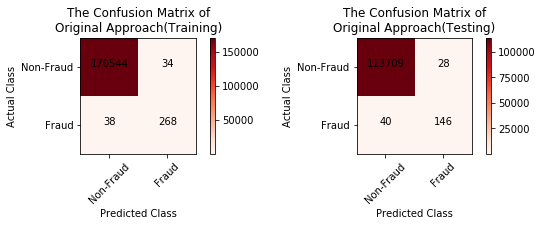

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             1.000           0.999
Recall               0.876           0.785
Precision            0.887           0.839
F1 Score             0.882           0.811



In [19]:
designed_confusion_matrix(y_train, original_Neural_pred_train, "The Confusion Matrix of\nOriginal Approach(Training)",
                          y_test, original_Neural_pred_test, "The Confusion Matrix of\nOriginal Approach(Testing)",
                          ["Non-Fraud", "Fraud"])

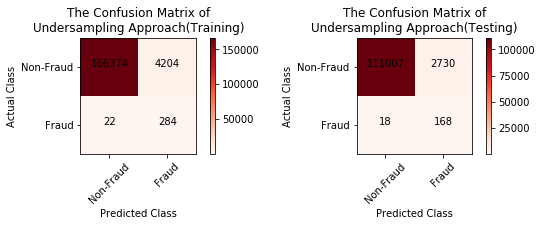

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.975           0.976
Recall               0.928           0.903
Precision            0.063           0.058
F1 Score             0.118           0.109



In [20]:
designed_confusion_matrix(y_train, undersample_Neural_pred_train, "The Confusion Matrix of\nUndersampling Approach(Training)",
                          y_test, undersample_Neural_pred_test, "The Confusion Matrix of\nUndersampling Approach(Testing)",
                          ["Non-Fraud", "Fraud"])

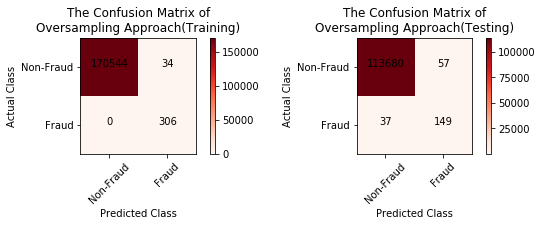

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             1.000           0.999
Recall               1.000           0.801
Precision            0.900           0.723
F1 Score             0.947           0.760



In [21]:
designed_confusion_matrix(y_train, oversampling_Neural_pred_train, "The Confusion Matrix of\nOversampling Approach(Training)",
                          y_test, oversampling_Neural_pred_test, "The Confusion Matrix of\nOversampling Approach(Testing)",
                          ["Non-Fraud", "Fraud"])

Although the accuracy against both training data and testing data for each model seems acceptable, it doesn't make any sense to simply take the accuracy as the only performance metric in this case. Due to the highly imbalanced feature, even if the model predicts all records as non-fraud transactions, the accuracy will be as high as 99%. Thus, other metrics, such as Recall, Precision, and F1 Score, are introduced here in order to better evaluate the model performance.

As illustrated from the results, all the accuracies are satisfied, but not the other metrics. To be more specific, the F1 Score is undesirable in Undersampling approach as 0.109 against testing data, while is around 0.811 in Original approach and 0.760 in Oversampling approach. The reason for this performance is that there are too many non-fraud cases that are misclassified as being fraud in the model built by the Undersampling approach. This could be a scenario that a cardholder gets blocked when purchasing because the bank's algorithm thought the purchase was a fraud. That's why in this case we shouldn't emphasize only in detecting fraud cases but we should also emphasie correctly categorizing non-fraud transactions.

Another interesting finding is that, although considered a "blackbox" in terms of interpretability, Neural Networks work successfully in the Oversampling and Original approach. Most of the fraud cases have been detected as well as correctly classifying the non-fraud transactions. It suggests that Neural Network relies heavily on having sufficient data for training purposes, which is the major problem in the Undersampling approach. However, notice that, in Oversampling approach, the Neural Network model performs perfectly in the training data, but slightly worse in the testing data, which seems like a overfitting issue. This also could be a common issue in Neural Network, the risk of obtaining weights that lead to a local optimum rather than the global optimum, in the sense that the weights converge to values that do not provide the best fit to the training data. In this case, we can try to avoid this situation by controlling the learning rate and slowly reducing the momentum. However, there is no guarantee that the resulting weights are indeed the optimal ones.